# Predict Ethereum Close Price with Prophet

* https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import torch

from data   import standarizer, \
                   features_target_split, \
                   train_test_split

import pytorch_common.util    as pu
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [4]:
def plot(y_pred, y_true, times=100):
    sns.set_style("darkgrid")
    plt.plot(y_true[:times], color='green',label="True")        
    plt.plot(y_pred[:times], color='blue', label="Prediction")
    plt.legend()
    plt.show()

## Setup

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('gpu')

In [7]:
pu.get_device()

device(type='cuda', index=0)

In [8]:
torch.cuda.is_available()

True

In [9]:
torch.__version__

'1.11.0'

In [10]:
sns.set(rc = {'figure.figsize':(15,8)})

In [11]:
DATASET_PATH = '../datasets/ETH_1H.csv'

## Preprocessing

In [30]:
def preprocessing(dataset, column, test_percent = 0.1):
    dataset.columns = dataset.columns.str.lower()
    dataset.columns
    dataset       = dataset[['date', column]]
    dataset       = dataset.rename(columns={'date': 'ds', column: 'y' })
    dataset['ds'] = pd.to_datetime(dataset['ds'])
    dataset       = dataset.sort_values(by='ds',ascending=True)
    
    train_set, test_set           = train_test_split(dataset, test_percent = test_percent)
    norm_train_set, norm_test_set = standarizer(train_set, test_set, columns=['y'])

    norm_train_set = norm_train_set[['ds', 'norm_y']]
    norm_train_set = norm_train_set.rename(columns={'norm_y': 'y' })


    return norm_train_set, norm_test_set

In [31]:
dataset = pd.read_csv(DATASET_PATH)

train_set, test_set = preprocessing(dataset, 'close', test_percent = 0.1)

train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3450 entries, 34496 to 31047
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3450 non-null   datetime64[ns]
 1   y       3450 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 80.9 KB


In [28]:
train_set.tail()

,ds,y
31051,2016-09-30 02:00:00,0.470695
31050,2016-09-30 03:00:00,0.470695
31049,2016-09-30 04:00:00,0.470695
31048,2016-09-30 05:00:00,0.470695
31047,2016-09-30 06:00:00,0.470695


In [27]:
test_set.head()

,ds,y,norm_y
31047,2016-09-30 06:00:00,13.23,0.470695
31046,2016-09-30 07:00:00,13.14,0.416703
31045,2016-09-30 08:00:00,13.14,0.416703
31044,2016-09-30 09:00:00,13.14,0.416703
31043,2016-09-30 10:00:00,13.14,0.416703


# Model Definition

In [14]:
model = Prophet(
    interval_width=0.95, 
    daily_seasonality=True
)

In [15]:
model.fit(train_set)

2022-08-14 16:55:36,198 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-08-14 16:55:36,208 - DEBUG - input tempfile: /var/tmp/tmpod37ptsi/mb5k0dow.json
2022-08-14 16:55:36,220 - DEBUG - input tempfile: /var/tmp/tmpod37ptsi/kpea16tg.json
2022-08-14 16:55:36,221 - DEBUG - idx 0
2022-08-14 16:55:36,221 - DEBUG - running CmdStan, num_threads: None
2022-08-14 16:55:36,221 - DEBUG - CmdStan args: ['/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78381', 'data', 'file=/var/tmp/tmpod37ptsi/mb5k0dow.json', 'init=/var/tmp/tmpod37ptsi/kpea16tg.json', 'output', 'file=/var/tmp/tmpfcw9ej8s/prophet_model-20220814165536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:55:36 - cmdstanpy - INFO - Chain [1] start processing
2022-08-14 16:55:36,222 - INFO - Chain [1] start processing
16:55:36 - cmdstanpy - INFO - Chain [1] done processing
2022-08-14 16:55:36,497 - INF

<prophet.forecaster.Prophet object at 0x7f66b76275e0>

In [48]:
test_set_dates = train_set[['ds']]
test_set_dates = test_set_dates.head(1000)

In [49]:
forecast = model.predict(test_set_dates)

In [50]:
results = train_set.merge(forecast, on='ds')

In [51]:
results = results[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']]
results.head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2016-05-09 13:00:00,-1.736967,-1.617175,-2.797096,-0.341445
1,2016-05-09 14:00:00,-1.467009,-1.609892,-2.820476,-0.425200
2,2016-05-09 15:00:00,-1.473008,-1.606160,-2.760947,-0.399098
3,2016-05-09 16:00:00,-1.568993,-1.603338,-2.788300,-0.484963
4,2016-05-09 17:00:00,-1.772962,-1.598483,-2.806282,-0.445933


In [52]:
def plot(y_pred, y_true):
    sns.set_style("darkgrid")
    plt.plot(y_true, color='green',label="True")        
    plt.plot(y_pred, color='blue', label="Prediction")
    plt.legend()
    plt.show()

<Figure size 1080x576 with 1 Axes>

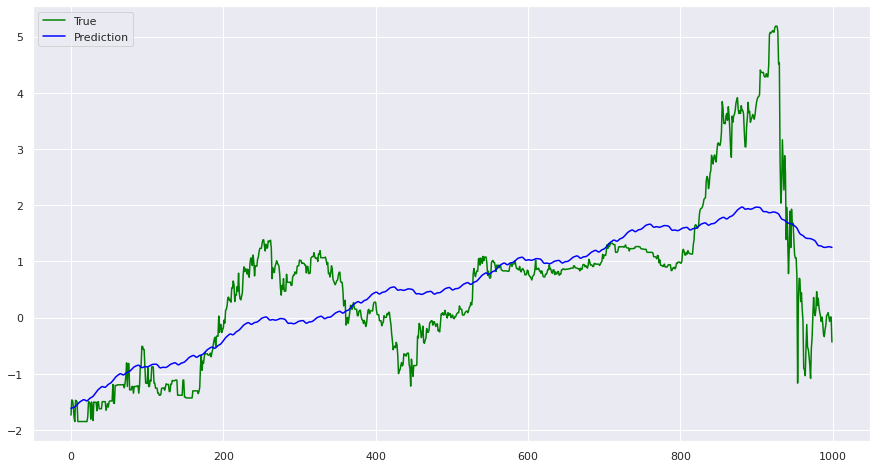

In [53]:
plot(results.yhat.values, results.y.values)

<Figure size 720x432 with 1 Axes>

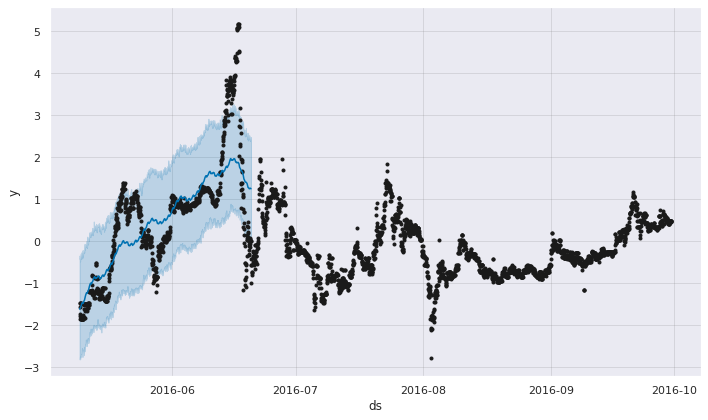

<Figure size 720x432 with 1 Axes>

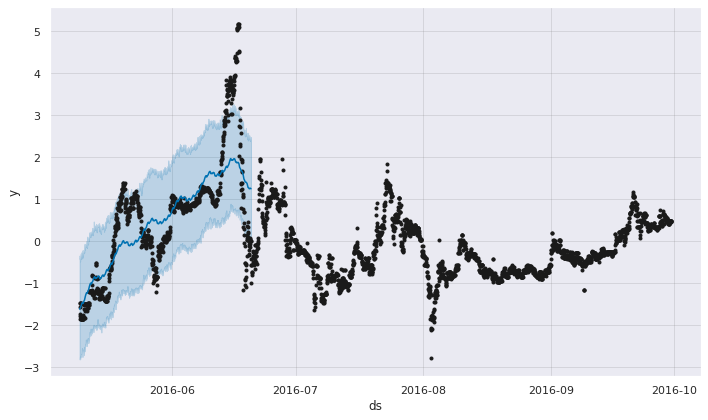

In [55]:
model.plot(forecast)